In [1]:
from autoencoder.unet import UNet
from ClickRef.model import Click_ref
import torch
from autoencoder.dataloader import * 
import matplotlib.pyplot as plt
from tqdm import tqdm
from create_gt_grids import Gtgrid
# from data_viz import *
from sklearn.metrics import pairwise_distances
from autoencoder.utils import *
from autoencoder.find_same_nucleis import FindSame2
from grids_to_clicks import Grid_to_click
from ClickRef.metrics import model_predict_with_click

In [2]:
autoencoder = UNet(3,3).cuda()
autoencoder.load_state_dict(torch.load('autoencoder/weights_autoencoder_CAE'))
click_ref = Click_ref(7,3)
click_ref.load_state_dict(torch.load('ClickRef/weights'))
click_ref.cuda()

Click_ref(
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
  (conv_corr1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_corr2): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
  )
  (conv_corr3): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
  )
  (conv_corr4): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu): ReLU()
  )
  (conv_corr5): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
  )
  (conv_corr6): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
  )
  (conv_corr7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_prob1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_prob2): Conv2d_new(
    (

In [3]:
filename = os.listdir(path_images)[25]
image_input = tifffile.imread(os.path.join(path_images,filename))/255
image = torch.tensor(np.transpose(image_input,(-1,0,1))[None]).cuda().float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


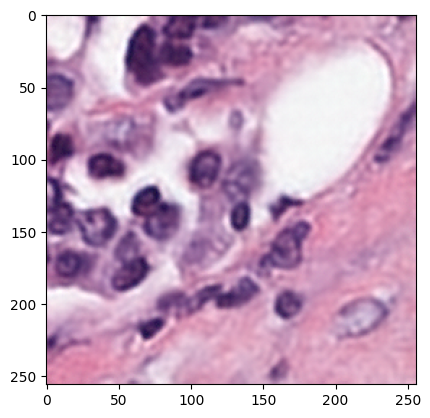

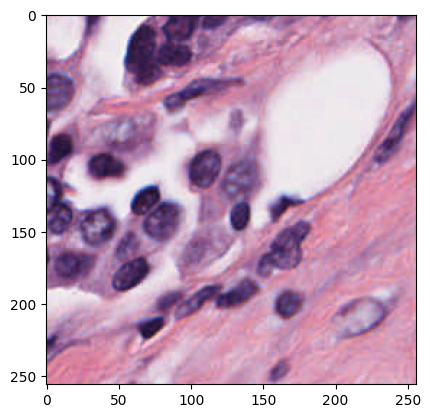

In [4]:
img = np.transpose(autoencoder(image)[0].cpu().detach().numpy()[0],(1,2,0))
plt.imshow(img)
plt.show()
plt.imshow(image_input)
plt.show()

### choose image support and error localization

In [7]:
f = FindSame2(df_test,
              autoencoder,
              threshold_images=5,
              threshold_nucleis=0.5)

100%|███████████████████████████████████████████| 38/38 [00:04<00:00,  7.61it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


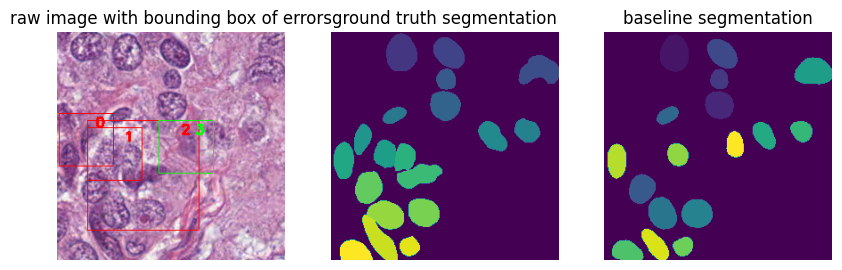

In [12]:
f.extract_errors(20)
f.show_errors_loc()
f.threshold_images = 3
f.select_images_near()
f.threshold_nucleis = 0.05
(
    images_near,
    images_with_same_errors_detected,
    sub_dataset,
    grids,
    filenames_near,
) = f.find_same_nuclei()


fp 1
merge 0
split 0
fn 5


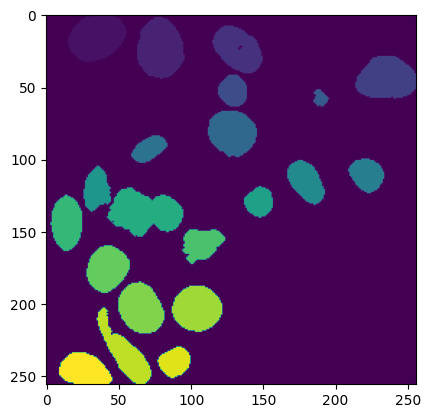

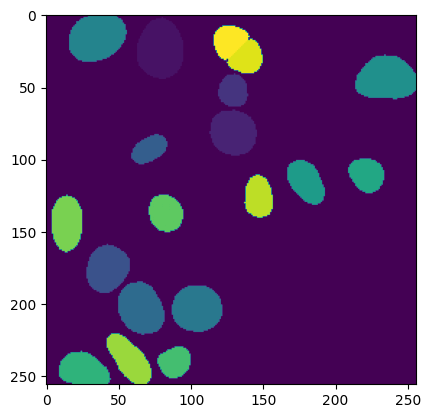

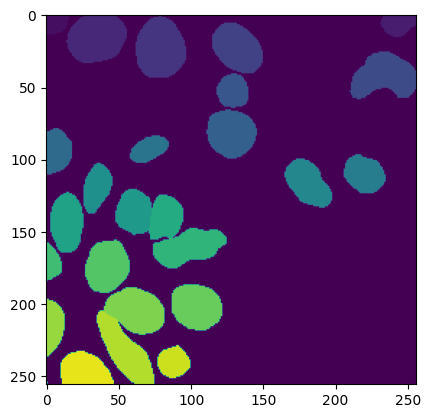

In [10]:
index = 0 
filename = filenames_near[index]
grid = grids[index]
path_baseline = path_stardist_modified
g = Grid_to_click(grid, filename, path_baseline)
click = g.final_click()
bef, out,baseline = model_predict_with_click(filename,
                  click_ref,
                  path_stardist_modified,
                  path_contour_stardist_modified,
                  path_binary_stardist_modified,
                  click,
                  count_erase = 15,
                  radius = 3)

plt.imshow(bef)
plt.show()


baseline = tifffile.imread(os.path.join(path_stardist_modified,filename))
gt = tifffile.imread(os.path.join(path_gt,filename))
plt.imshow(baseline)
plt.show()
plt.imshow(gt)
plt.show()